In [1]:
%matplotlib inline

In [3]:
import numpy as np

In [2]:
import pandas as pd

# calculate accuracy measures and confusion matrix
from sklearn import metrics

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:
from sklearn.feature_extraction.text import CountVectorizer  #DT does not take strings as input for the model fit step....

In [4]:
credit_df = pd.read_csv("credit.csv")

In [5]:
credit_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
months_loan_duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
percent_of_income,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
years_at_residence,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
existing_loans_count,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
dependents,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


In [8]:
credit_df.head(10)  #let us look at the raw data. As is evident, there are lot of missing values 

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes
5,unknown,36,good,education,9055,unknown,1 - 4 years,2,4,35,none,other,1,unskilled,2,yes,no
6,unknown,24,good,furniture/appliances,2835,500 - 1000 DM,> 7 years,3,4,53,none,own,1,skilled,1,no,no
7,1 - 200 DM,36,good,car,6948,< 100 DM,1 - 4 years,2,2,35,none,rent,1,management,1,yes,no
8,unknown,12,good,furniture/appliances,3059,> 1000 DM,4 - 7 years,2,4,61,none,own,1,unskilled,1,no,no
9,1 - 200 DM,30,critical,car,5234,< 100 DM,unemployed,4,2,28,none,own,2,management,1,no,yes


In [207]:
credit_df.shape

(1000, 17)

In [208]:
credit_df.describe(include=[np.number])


,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [12]:
credit_df.info()  # many columns are of type object i.e. strings. These need to be converted to ordinal type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
checking_balance        1000 non-null int8
months_loan_duration    1000 non-null int64
credit_history          1000 non-null int8
purpose                 1000 non-null int8
amount                  1000 non-null int64
savings_balance         1000 non-null int8
employment_duration     1000 non-null int8
percent_of_income       1000 non-null int64
years_at_residence      1000 non-null int64
age                     1000 non-null int64
other_credit            1000 non-null int8
housing                 1000 non-null int8
existing_loans_count    1000 non-null int64
job                     1000 non-null int8
dependents              1000 non-null int64
phone                   1000 non-null int8
default                 1000 non-null int8
dtypes: int64(7), int8(10)
memory usage: 64.5 KB


In [9]:
# Decision tree in Python can take only numerical / categorical colums. It cannot take string / obeject types. 
# The following code loops through each column and checks if the column type is object then converts those columns
# into categorical with each distinct value becoming a category or code.

for feature in credit_df.columns: # Loop through all columns in the dataframe
    if credit_df[feature].dtype == 'object': # Only apply for columns with categorical strings
        credit_df[feature] = pd.Categorical(credit_df[feature]).codes # Replace strings with an integer

In [7]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
checking_balance        1000 non-null object
months_loan_duration    1000 non-null int64
credit_history          1000 non-null object
purpose                 1000 non-null object
amount                  1000 non-null int64
savings_balance         1000 non-null object
employment_duration     1000 non-null object
percent_of_income       1000 non-null int64
years_at_residence      1000 non-null int64
age                     1000 non-null int64
other_credit            1000 non-null object
housing                 1000 non-null object
existing_loans_count    1000 non-null int64
job                     1000 non-null object
dependents              1000 non-null int64
phone                   1000 non-null object
default                 1000 non-null object
dtypes: int64(7), object(10)
memory usage: 132.9+ KB


In [38]:
credit_df.head(10)  #l

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no
5,unknown,36,good,education,9055,unknown,1 - 4 years,2,4,35,none,other,1,unskilled,2,yes
6,unknown,24,good,furniture/appliances,2835,500 - 1000 DM,> 7 years,3,4,53,none,own,1,skilled,1,no
7,1 - 200 DM,36,good,car,6948,< 100 DM,1 - 4 years,2,2,35,none,rent,1,management,1,yes
8,unknown,12,good,furniture/appliances,3059,> 1000 DM,4 - 7 years,2,4,61,none,own,1,unskilled,1,no
9,1 - 200 DM,30,critical,car,5234,< 100 DM,unemployed,4,2,28,none,own,2,management,1,no


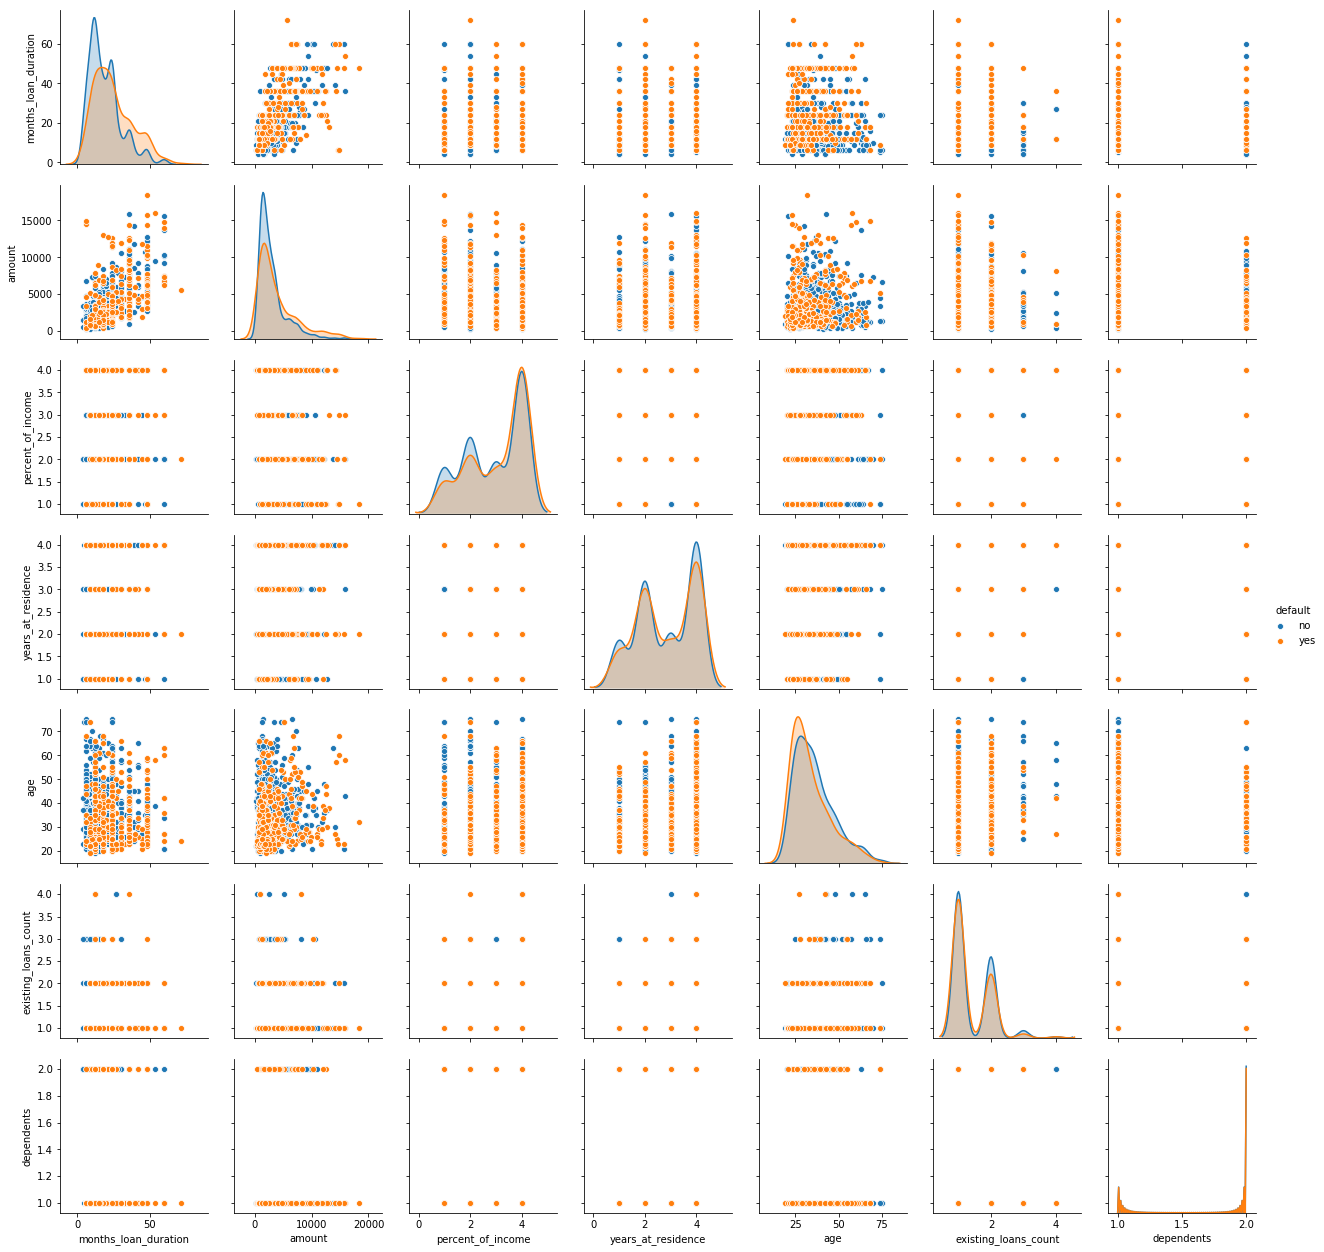

In [6]:
# Pairplot using sns
import seaborn as sns
sns.pairplot(credit_df, hue = "default")

In [8]:
col_labels = [ 'checking_balance', 'months_loan_duration' ,'credit_history' , 'purpose, amount', 'savings_balance' , 'employment_duration'
, 'percent_of_income', 'years_at_residence', 'age', 'other_credit', 'housing', 'existing_loans_count', 'job', 'dependents', 'phone', 'default']

In [37]:
train_char_label = ['No', 'Yes']

In [40]:
train_set = credit_df.head(500) # we should be using random function in production environments
test_set = credit_df.tail(500)  # we should be using random function in production environments
train_labels = train_set.pop("default")
test_labels = test_set.pop("default")

KeyError: 'default'

In [44]:
# capture the target column ("default") into separate vectors for training set and test set

X = credit_df.drop("default" , axis=1)

y = credit_df.pop("default")




KeyError: "['default'] not found in axis"

In [29]:
# splitting data into training and test set for independent attributes
from sklearn.model_selection import train_test_split

X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size=.30, random_state=1)


In [32]:
# invoking the decision tree classifier function. Using 'entropy' method of finding the split columns. Other option 
# could be gini index.  Restricting the depth of the tree to 5 (no particular reason for selecting this)

#dt_model = DecisionTreeClassifier(criterion = 'entropy' , max_depth = 5, random_state = 100)
                                  
dt_model = DecisionTreeClassifier(criterion = 'entropy' )

In [33]:
dt_model.fit(train_set, train_labels)

ValueError: could not convert string to float: '< 0 DM'

In [153]:
from IPython.display import Image  
#import pydotplus as pydot
from sklearn import tree
from os import system

Credit_Tree_File = open('d:\credit_tree.dot','w')
dot_data = tree.export_graphviz(dt_model, out_file=Credit_Tree_File, feature_names = list(train_set), class_names = list(train_char_label))

Credit_Tree_File.close()


# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = train_set.columns))


                           Imp
checking_balance      0.048315
months_loan_duration  0.095289
credit_history        0.033223
purpose               0.073685
amount                0.235281
savings_balance       0.054431
employment_duration   0.036024
percent_of_income     0.059060
years_at_residence    0.056180
age                   0.138229
other_credit          0.022864
housing               0.039585
existing_loans_count  0.016997
job                   0.039726
dependents            0.047536
phone                 0.003574


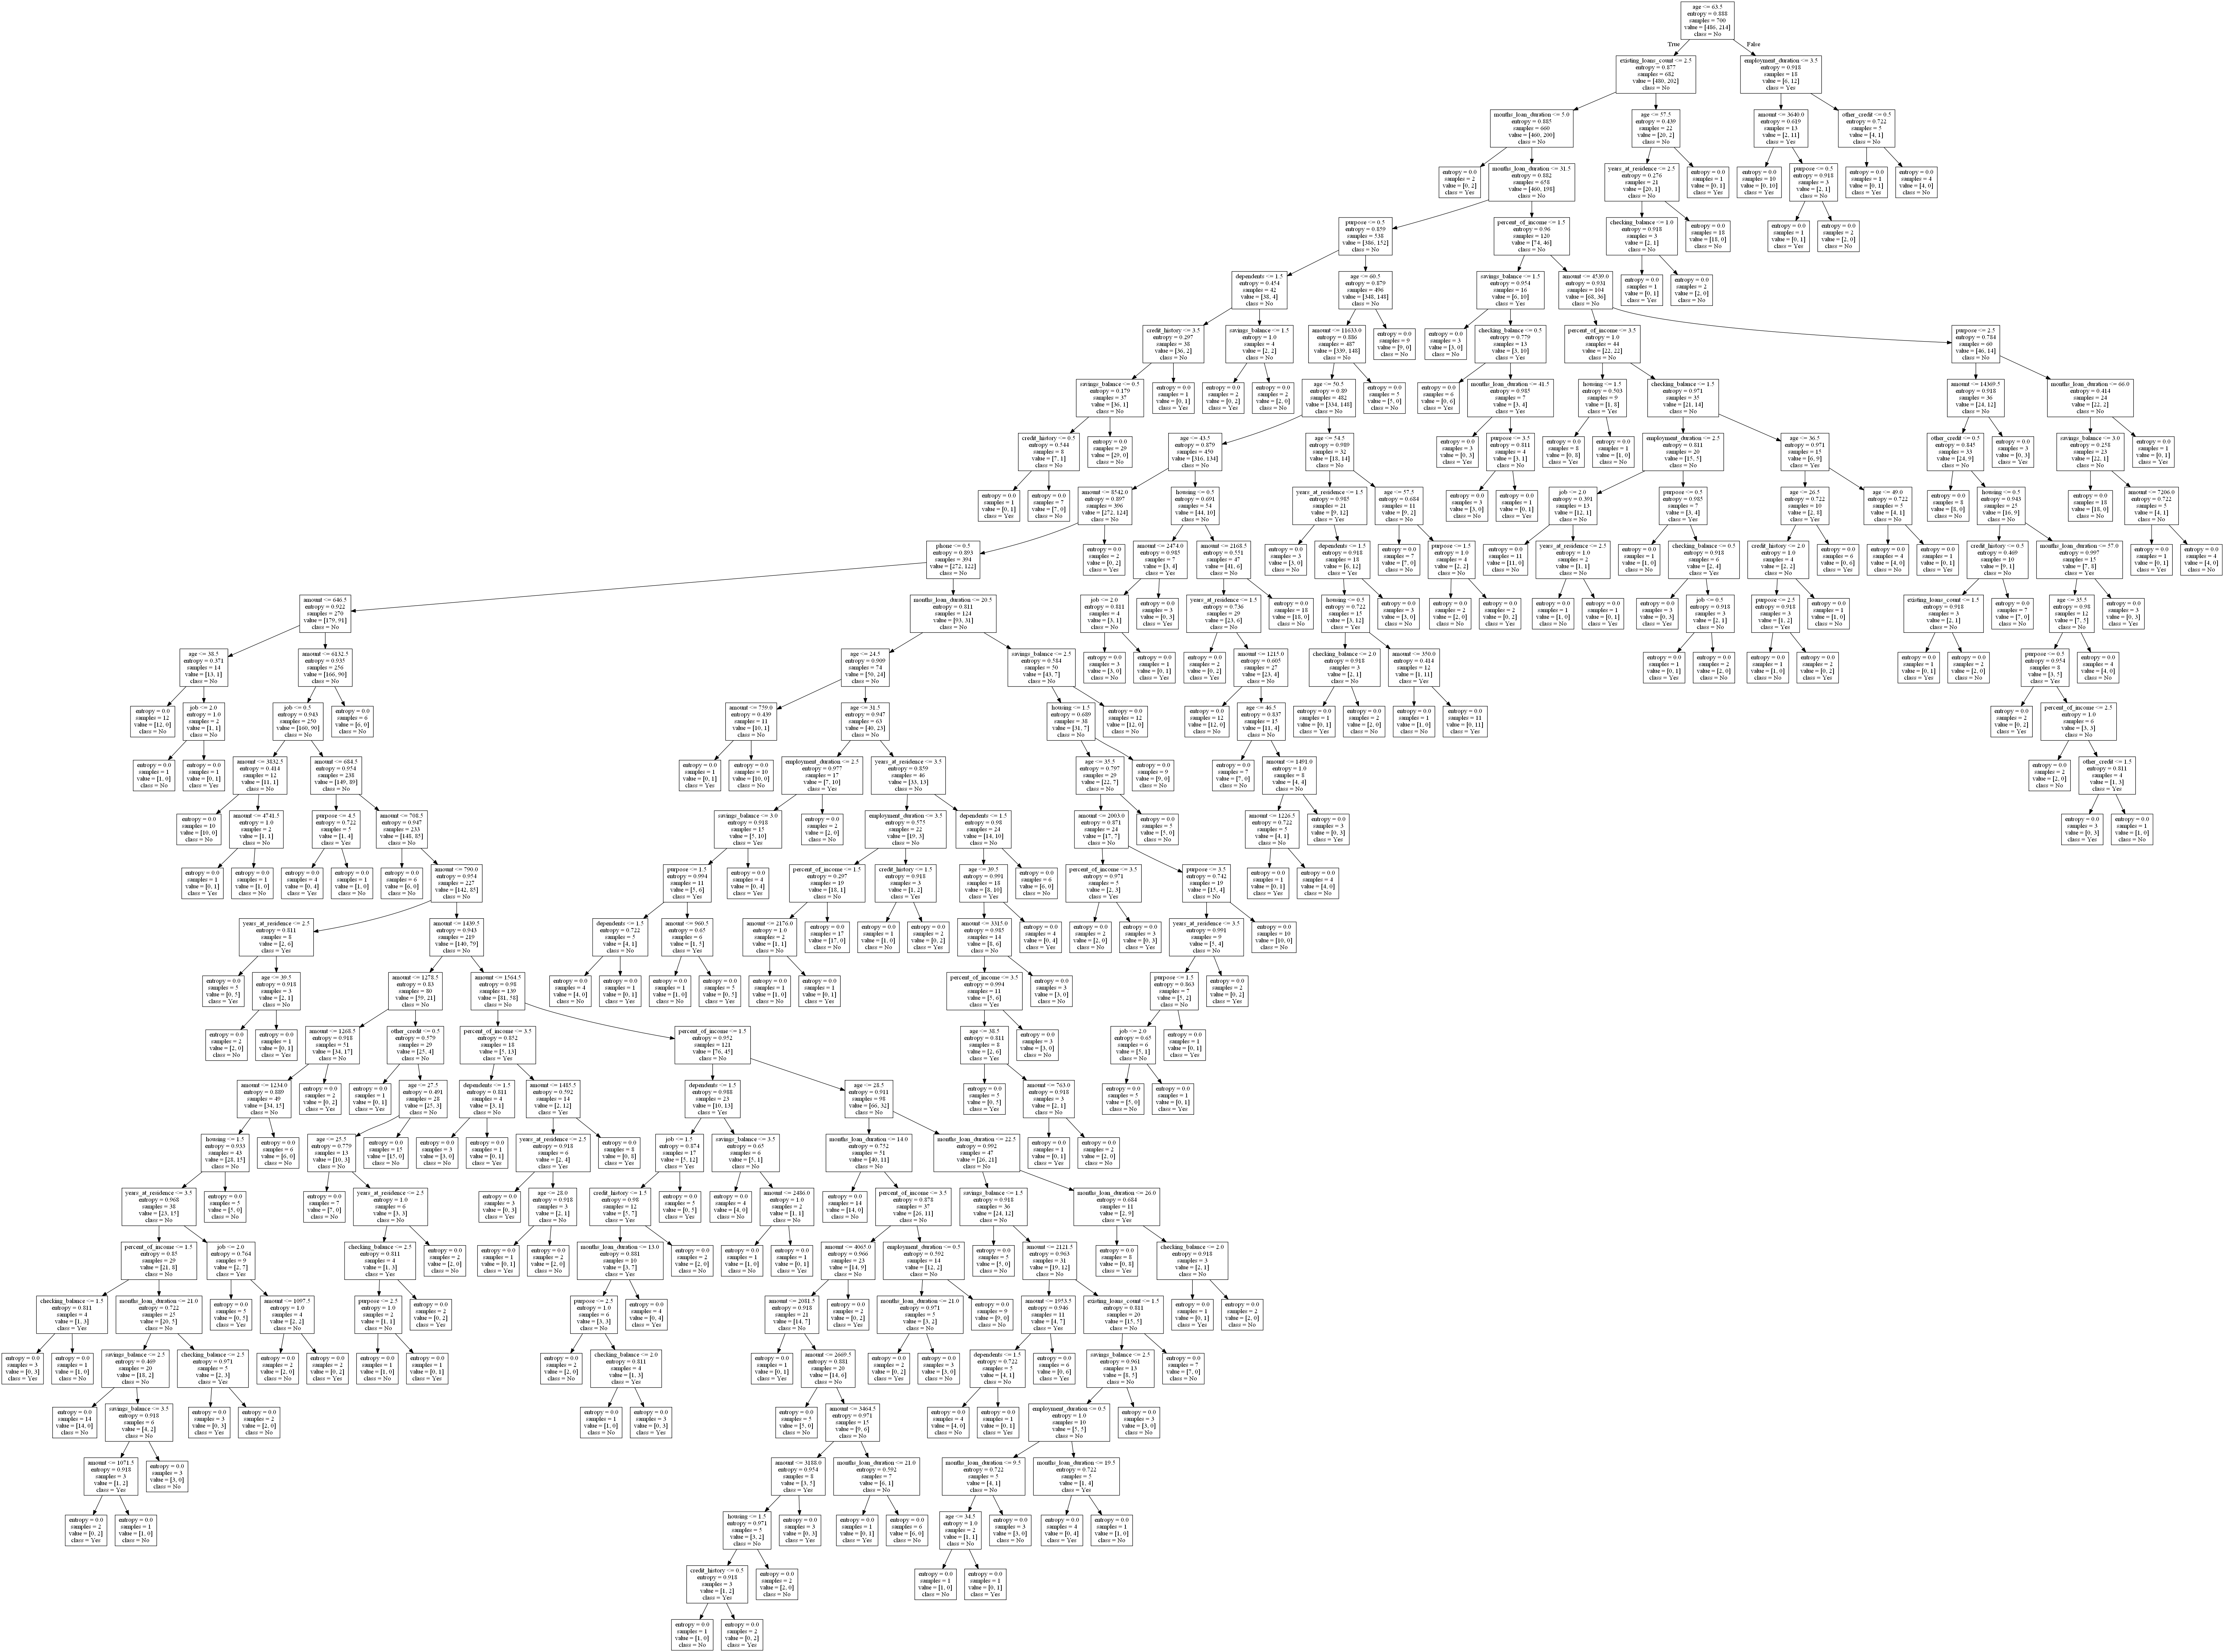

In [154]:
# You can also copy the script in the .dot file and paste it at http://webgraphviz.com/ to get tree view 
#or create a .png as below

system("dot -Tpng D:\credit_tree.dot -o D:/credit_tree.png")
Image("d:\credit_tree.png")

In [155]:
y_predict = dt_model.predict(test_set)

In [159]:
print(dt_model.score(train_set , train_labels))
print(dt_model.score(test_set , test_labels))

1.0
0.54


In [160]:
print(metrics.confusion_matrix(test_labels, y_predict))

[[139  75]
 [ 63  23]]


In [ ]:
# Look at the class level metric for the defaulter class. It is poor. 

#                                      Regularising the Decision Tree

In [161]:

reg_dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7)
reg_dt_model.fit(train_set, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [162]:
credit_tree_regularized = open('d:\credit_tree_regularized.dot','w')
dot_data = tree.export_graphviz(reg_dt_model, out_file= credit_tree_regularized , feature_names = list(train_set), class_names = list(train_char_label))

credit_tree_regularized.close()

print (pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = train_set.columns))


                           Imp
checking_balance      0.048315
months_loan_duration  0.095289
credit_history        0.033223
purpose               0.073685
amount                0.235281
savings_balance       0.054431
employment_duration   0.036024
percent_of_income     0.059060
years_at_residence    0.056180
age                   0.138229
other_credit          0.022864
housing               0.039585
existing_loans_count  0.016997
job                   0.039726
dependents            0.047536
phone                 0.003574


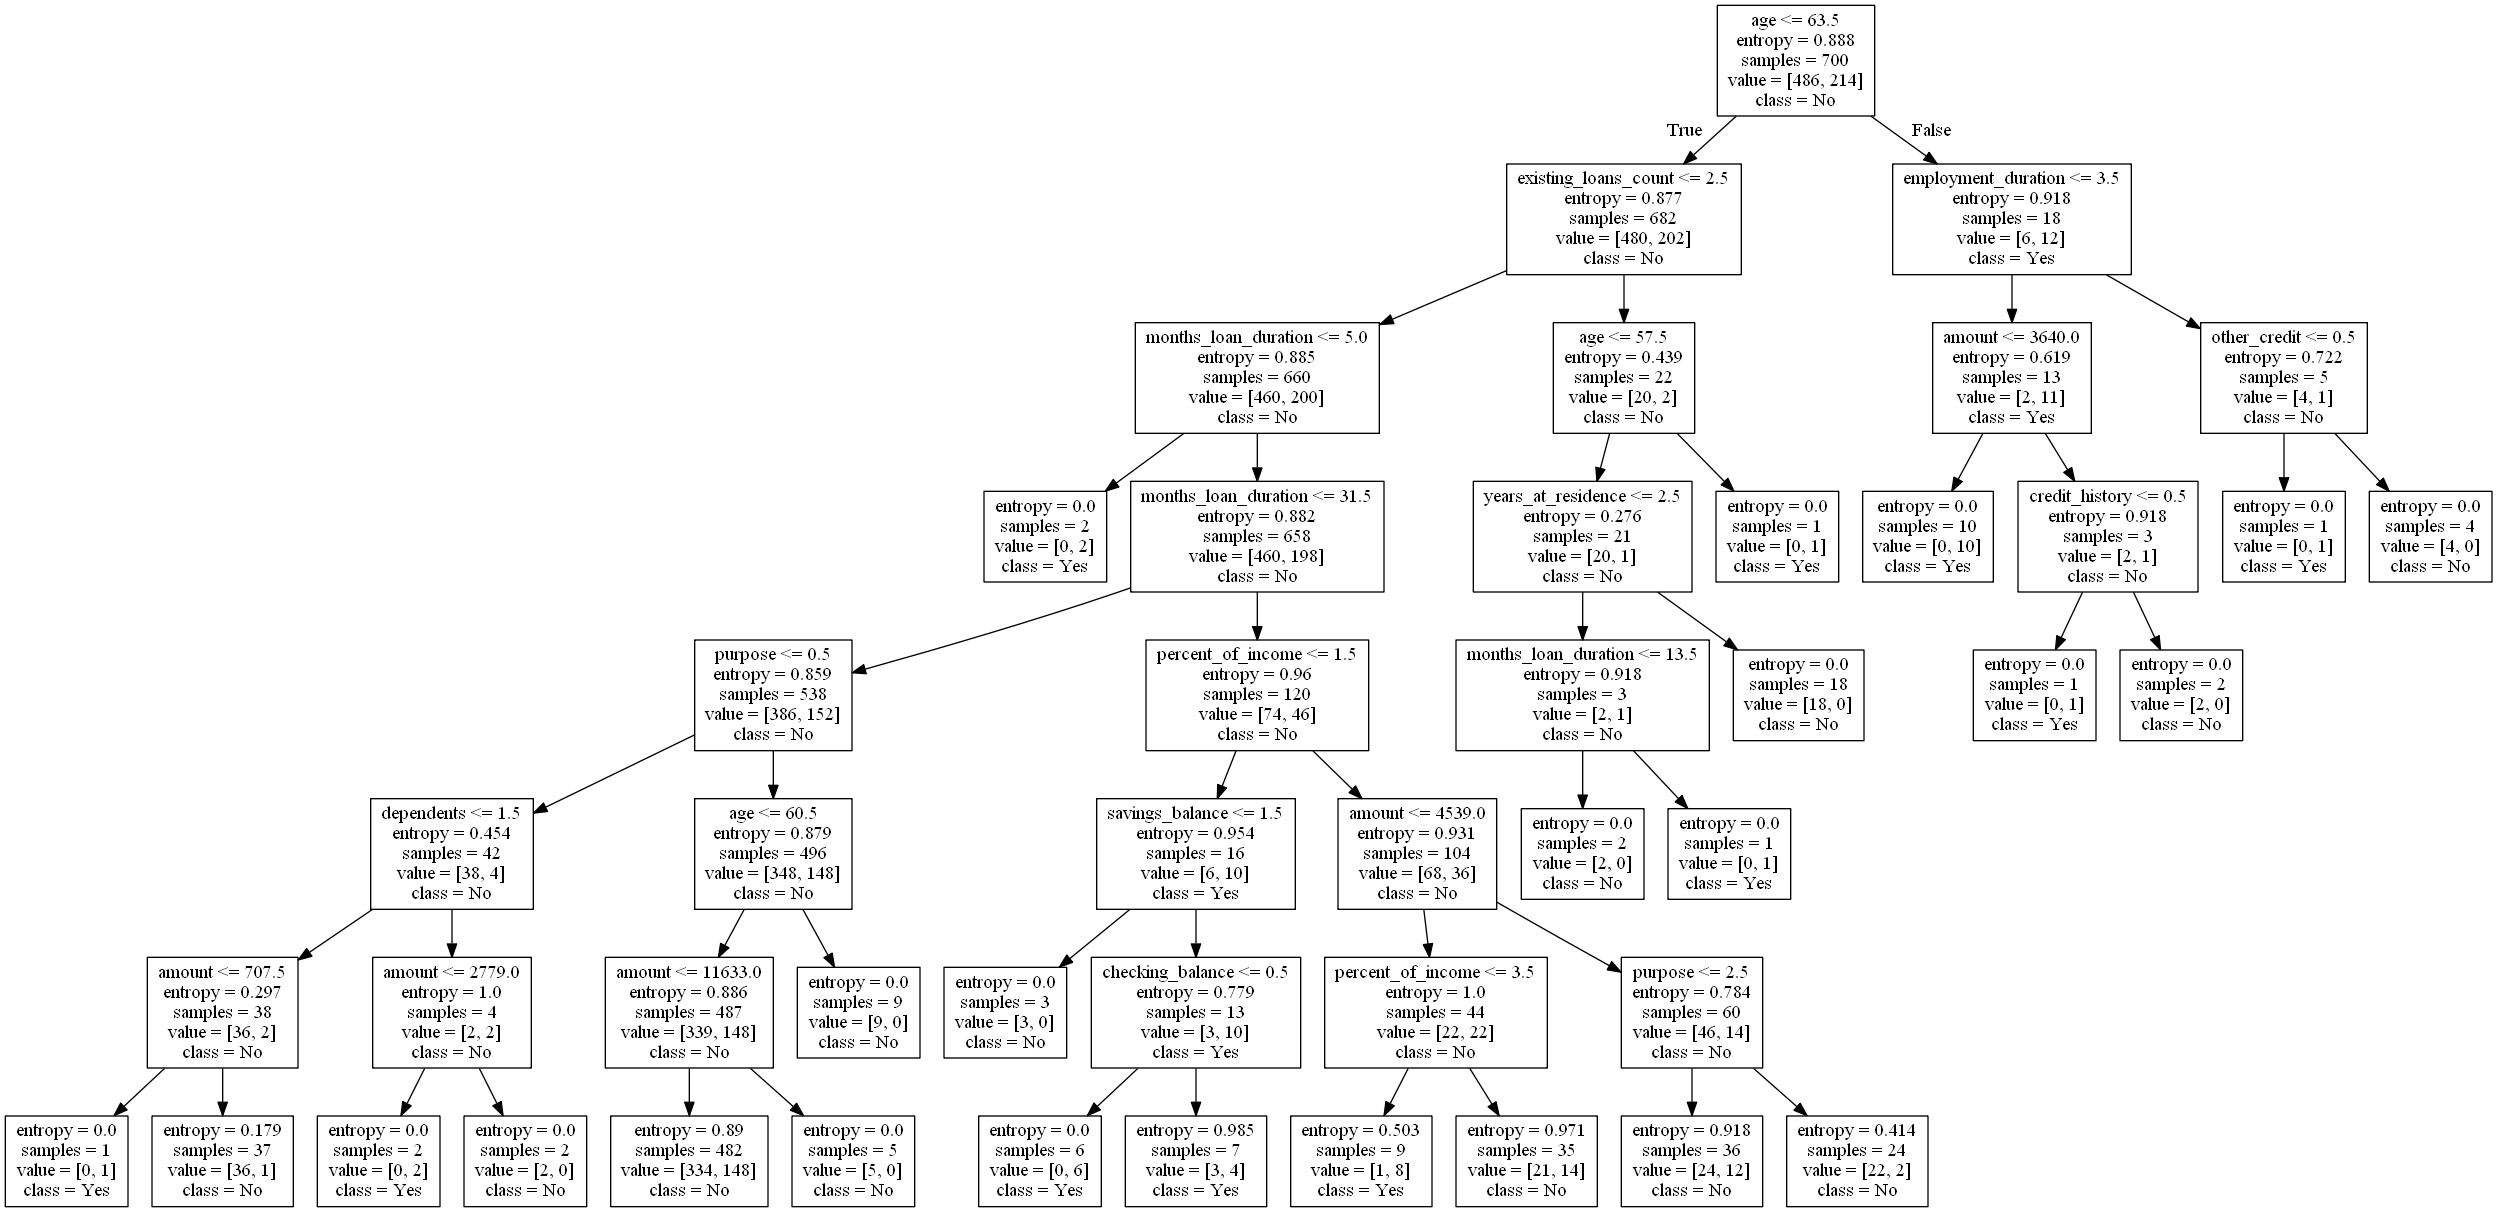

In [163]:
# You can also copy the script in the .dot file and paste it at http://webgraphviz.com/ to get tree view
# or create a .png as below
system("dot -Tpng D:\credit_tree_regularized.dot -o D:/credit_tree_regularized.png")
Image("d:\credit_tree_regularized.png")

In [164]:
y_predict = reg_dt_model.predict(test_set)

In [165]:
reg_dt_model.score(test_set , test_labels)

0.71

In [166]:
print(metrics.confusion_matrix(test_labels, y_predict))

[[205   9]
 [ 78   8]]


#                             Ensemble Learning - Bagging

In [183]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(base_estimator=dt_model, n_estimators=50)

#bgcl = BaggingClassifier(n_estimators=50)
bgcl = bgcl.fit(train_set, train_labels)


In [184]:
y_predict = bgcl.predict(test_set)

print(bgcl.score(test_set , test_labels))

print(metrics.confusion_matrix(test_labels, y_predict))

0.6666666666666666
[[194  20]
 [ 80   6]]


# Ensemble Learning - AdaBoosting

In [189]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier(base_estimator=dt_model, n_estimators=10)
#abcl = AdaBoostClassifier( n_estimators=50)
abcl = abcl.fit(train_set, train_labels)


In [190]:
y_predict = abcl.predict(test_set)
print(abcl.score(test_set , test_labels))

print(metrics.confusion_matrix(test_labels, y_predict))

0.5466666666666666
[[144  70]
 [ 66  20]]


#                     Ensemble Learning - GradientBoost

In [195]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50)
gbcl = gbcl.fit(train_set, train_labels)


In [196]:
y_predict = gbcl.predict(test_set)
print(gbcl.score(test_set , test_labels))
print(metrics.confusion_matrix(test_labels, y_predict))

0.6966666666666667
[[205   9]
 [ 82   4]]


# Ensemble RandomForest Classifier

In [200]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(train_set, train_labels)


In [201]:
y_predict = rfcl.predict(test_set)
print(rfcl.score(test_set , test_labels))
print(metrics.confusion_matrix(test_labels, y_predict))

0.6733333333333333
[[199  15]
 [ 83   3]]
